In [1]:
import os
import errno
import numpy as np 
import xarray as xr
import deepcell
from deepcell.applications import MultiplexSegmentation

In [63]:
# load data
#data_dir = '/data/patricia/20200320_Test_Run/'
data_dir = '/data/segmentation/20200227_IF_Testing/melanoma/'
#data_dir = '/data/alex/2020325_test_image/'
data_dir = '/data/segmentation/20200227_IF_Testing/test_data/eliot'
data_dir = '/data/segmentation/20200209_CyCIF/'
#data_dir = '/data/segmentation/datasets/20200226_Melanoma/20200521_christine'
#data_dir = '/data/segmentation/datasets/20200114_cHL/20200522_cHL_job/'
data_dir = '/data/segmentation/datasets/20200116_DCIS/20200618_DCIS'
#data_dir = '/data/segmentation/datasets/20191219_Eliot/20200616_Eliot_Screen2/'
#data_dir = '/data/segmentation/20200616_Model_Assessment'
data_dir = '/data/selena/20200703_GI_test/'

In [65]:
cohort_xr = xr.open_dataarray(os.path.join(data_dir,'deepcell_input_selena.xr'))
cohort_xr.shape

(1, 1024, 1024, 2)

In [54]:
vals = np.zeros(list(cohort_xr.shape[:-1]) + [2])
vals[:, :, :, 0] = cohort_xr.values[..., 0]

In [5]:
app = MultiplexSegmentation(use_pretrained_weights=False)

W0703 16:23:22.604435 139757658732352 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# whole-cell
weights = "/data/models/20200610_param_tuning/20200612_all_data_512x512_deep_watershed_all_params.h5"

In [7]:
app.model.load_weights(weights)

In [67]:
resized_input = app._resize_input(cohort_xr.values, image_mpp=2)
resized_input.shape

(1, 1024, 1024, 2)

In [68]:
inner_distance, outer_distance, fgbg, pixelwise = app._run_model(resized_input)

In [69]:
combined = np.concatenate((pixelwise[:, :, :, 1:2], pixelwise[:, :, :, 0:1], 
                           inner_distance, outer_distance, fgbg[:, :, :, 1:2]), axis=-1)
combined.shape

(1, 1024, 1024, 5)

In [70]:
from deepcell_toolbox.utils import resize
resized_output = resize(combined, cohort_xr.shape[1:3])
resized_output.shape

(1, 1024, 1024, 5)

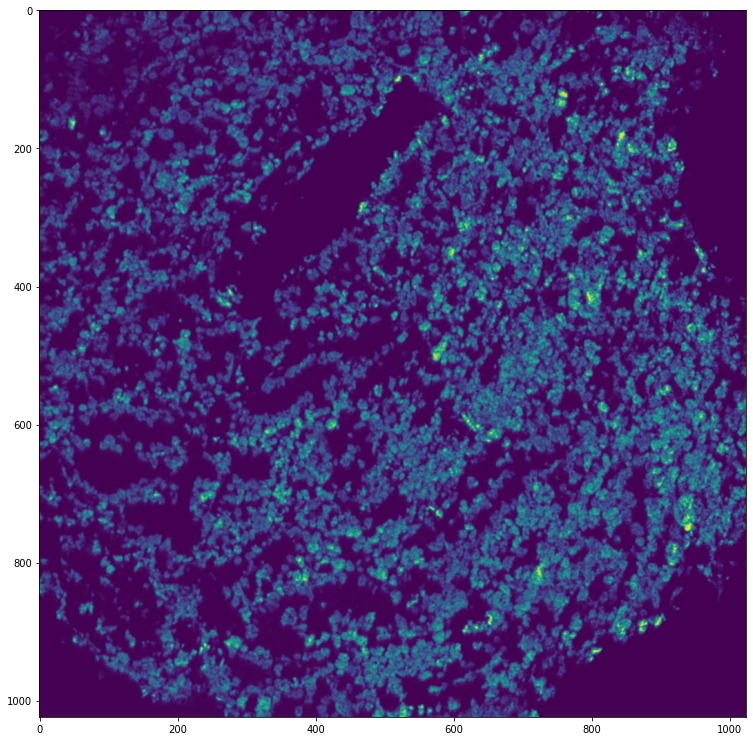

In [74]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[0, :, :, 0])

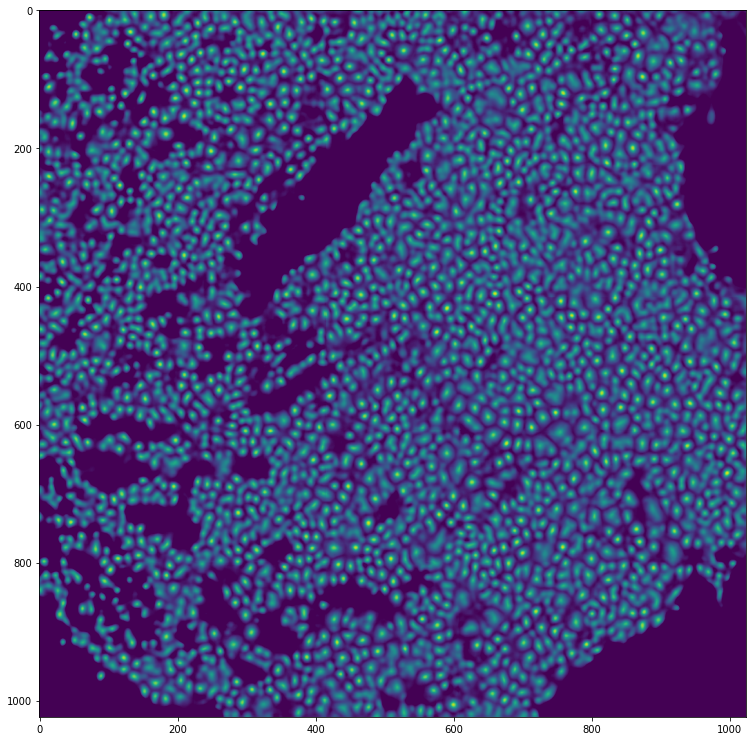

In [76]:
# Original IF_Test_8 model
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(resized_output[0, :, :, 2])

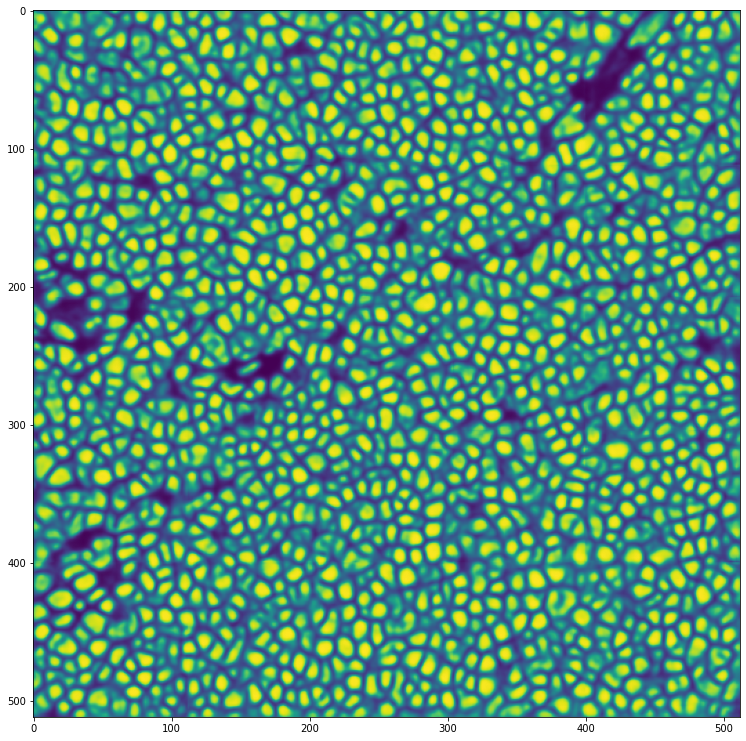

In [16]:
# working version
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(resized_output[18, :, :, 0])

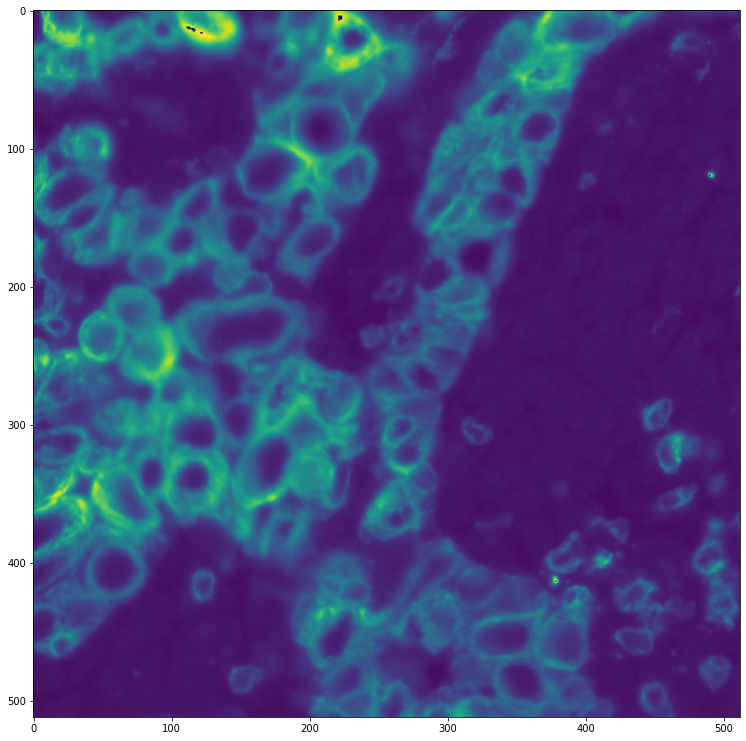

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[0, :, :, 1])

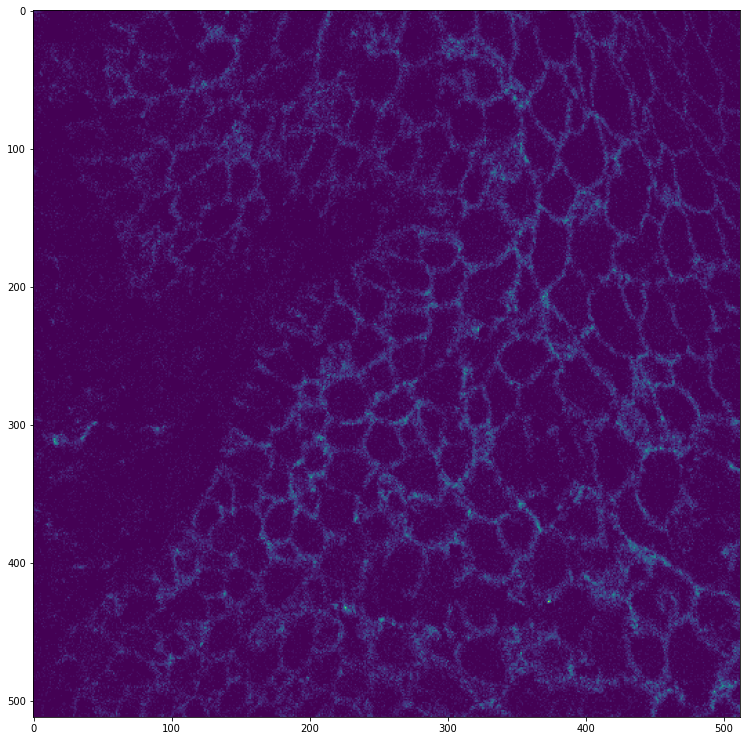

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[1, :, :, 1])

In [77]:
model_output = xr.DataArray(resized_output,
                         coords=[cohort_xr.coords['fovs'], range(cohort_xr.shape[1]), 
                                 range(cohort_xr.shape[2]), 
                                 ['pixelwise_interior', 'pixelwise_border', 'watershed_inner', 
                                  'watershed_outer', 'fgbg_foreground']],
                         dims=['fovs', 'rows', 'cols', 'models'])
model_output.to_netcdf(os.path.join(data_dir, "deepcell_output.xr"), format="NETCDF3_64BIT")

In [ ]:
# from deepcell.model_zoo.panopticnet import PanopticNet

# model = PanopticNet(
#     backbone='resnet50',
#     input_shape=(512,512, 2),
#     norm_method='std',
#     num_semantic_heads=4,
#     num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
#     location=True,  # should always be true
#     include_top=True)
# model.load_weights(weights)

In [ ]:
# from deepcell_toolbox.utils import resize
# resized_input = resize(cohort_xr.values, (cohort_xr.shape[1] * 2, cohort_xr.shape[2] *2))
# resized_input.shape

In [ ]:
# from deepcell_toolbox.utils import tile_image, untile_image
# test_data, test_info = tile_image(resized_input[:1], (512, 512), stride_ratio=0.75)
# test_images = model.predict(test_data)
# inner_distance, outer_distance, fgbg, pixelwise = test_images
# inner_distance_untile = untile_image(inner_distance, test_info, (512, 512))
# outer_distance_untile = untile_image(outer_distance, test_info, (512, 512))
# pixelwise_untile = untile_image(pixelwise, test_info, (512, 512))
# fgbg_untile = untile_image(fgbg, test_info, (512, 512))
# pixelwise_sum = pixelwise_untile[:, :, :, :1] + pixelwise_untile[:, :, :, 1:2]
# combined = np.concatenate((pixelwise_untile[:, :, :, 1:2], pixelwise_untile[:, :, :, 0:1], 
#                            inner_distance_untile, outer_distance_untile, fgbg_untile[:, :, :, 1:2],
#                           pixelwise_sum), axis=-1)
# combined.shape